# Demonstration of mask restriction in feature creation
Features are only created in the regions defined by the mask, saving on RAM, computation time and possibly accuracy

Practical implications: train/test split has to be made before masking (as splitting along subject dimension is not easily achievable anymore)


In [66]:
import sys

path_bnd = '../'
sys.path.insert(1, path_bnd)
import analysis_tools.data_loader as dl
from visual_tools.visual import display
import numpy as np

In [67]:
from gtda.homology import CubicalPersistence
from pgtda.diagrams import PersistenceEntropy, Amplitude, Filtering, Scaler
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion, make_union
from pgtda.images import RollingSubImageTransformer, make_image_union


## Import data

In [68]:
data_dir = '/Users/julian/stroke_research/brain_and_donuts/full_datasets'
clinical_inputs, ct_inputs, ct_lesion_GT, mri_inputs, mri_lesion_GT, brain_masks, ids, params = \
    dl.load_structured_data(data_dir, 'withAngio_all_2016_2017.npz')

# Reshape ct_inputs as it has 1 channel
ct_inputs = ct_inputs.reshape((*ct_inputs.shape[:-1]))

Loading a total of 113 subjects.
Sequences used: {'ct_sequences': ['wbetted_Angio'], 'ct_label_sequences': ['wcoreg_VOI'], 'mri_sequences': [], 'mri_label_sequences': []}
0 subjects had been excluded.


## Setting up data exploration set

In [69]:
# Data subset
n_images = 2
X = (ct_inputs[:n_images] * brain_masks[:n_images])[range(n_images), ::2, ::2, ::2]
y = (ct_lesion_GT[:n_images] * brain_masks[:n_images])[range(n_images), ::2, ::2, ::2]
mask = brain_masks[:n_images][range(n_images), ::2, ::2, ::2]

print(X.shape)
print(y.shape)
print(mask.shape)

(2, 40, 48, 40)
(2, 40, 48, 40)
(2, 40, 48, 40)


Image center:  19 23 19
Image center value:  -0.0
Image center:  19 23 19
Image center value:  False


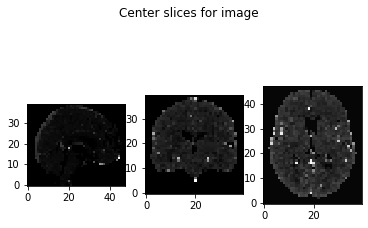

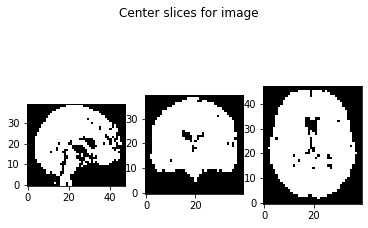

<module 'matplotlib.pyplot' from '/Users/julian/.conda/envs/BnDs/lib/python3.7/site-packages/matplotlib/pyplot.py'>

In [70]:
display(X[0])
display(mask[0])


## Subimage Creation

In [71]:
width_list = [[5, 5, 5], [7, 7, 7]]
n_widths = len(width_list)
X_subimages_width_list = [RollingSubImageTransformer(width=width, padding='same').fit_transform(X)
                          for width in width_list]
print(X_subimages_width_list[0].shape)
print(X_subimages_width_list[1].shape)

/Users/julian/.conda/envs/BnDs/lib/python3.7/site-packages/pgtda/images/pipeline.py:495: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

/Users/julian/.conda/envs/BnDs/lib/python3.7/site-packages/pgtda/images/pipeline.py:495: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



(2, 40, 48, 40, 5, 5, 5)
(2, 40, 48, 40, 7, 7, 7)


## Masking
Subimages are flattened to create a common voxel-level dimension and the subset defined by their mask is extracted

In [72]:
X_masked_subimages = []
for width_index, width in enumerate(width_list):
    # flatten along sample and spatial dimension to allow for masking 
    # (as the number of spatial samples in mask is not the same for every subject)
    flat_X_subimages = X_subimages_width_list[width_index].reshape(-1, width[0], width[1], width[2])
    X_masked_subimages.append(flat_X_subimages[mask.reshape(-1)])
print(X_masked_subimages[0].shape)
print(X_masked_subimages[1].shape)

(55969, 5, 5, 5)
(55969, 7, 7, 7)


In [73]:
y_masked = y.reshape(-1)[mask.reshape(-1)]
y_masked.shape

(55969,)

## Feature creation

In [74]:
transformer = make_pipeline(CubicalPersistence(homology_dimensions=(0, 1, 2), n_jobs=-1),
                            make_union(PersistenceEntropy(n_jobs=-1),
                                       Amplitude(metric='wasserstein', metric_params={'p': 2}, order=None, n_jobs=-1)))
X_masked_subfeatures_per_width = [transformer.fit_transform(X_masked_subimages[width_index]) for width_index in range(n_widths)]
print(X_masked_subfeatures_per_width[0].shape)
print(X_masked_subfeatures_per_width[1].shape)

(55969, 6)
(55969, 6)


In [75]:
X_masked_subfeatures = np.concatenate(X_masked_subfeatures_per_width, axis=-1)
X_masked_subfeatures.shape

(55969, 12)

## Rebuilding 3D feature image
The 3D feature image is rebuild by filling the area defined by the mask with the selected feature obtained before. The background can be filled with a given value.

In [76]:
feature_index = 0
vxl_index = 0
background_value = 0
X_3D_feature = np.full(mask.shape, background_value, dtype = np.float64) # fill shape with background
for subj in range(n_images):
    subj_n_vxl = np.sum(mask[subj])
    subj_features = X_masked_subfeatures[vxl_index : vxl_index + subj_n_vxl]
    X_3D_feature[subj][mask[subj]] = subj_features[:, feature_index]
    vxl_index += subj_n_vxl
X_3D_feature.shape

(2, 40, 48, 40)

Image center:  19 23 19
Image center value:  0.0


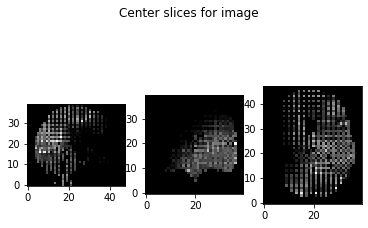

<module 'matplotlib.pyplot' from '/Users/julian/.conda/envs/BnDs/lib/python3.7/site-packages/matplotlib/pyplot.py'>

In [77]:
display(X_3D_feature[0])
